In [3]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.1 MB/s eta 0:00:00


In [4]:
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_v2_m, EfficientNet_V2_M_Weights
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import torch
import os
import cv2
import random
from torchvision import datasets, models, transforms
from PIL import Image
import timm

In [5]:
drive.mount('/content/drive/')
data_dir = '/content/drive/MyDrive/VISIOPE_PROJECT/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive/


In [6]:
%cd /content/drive/MyDrive/VISIOPE_PROJECT/models

/content/drive/MyDrive/VISIOPE_PROJECT/models


## Prediction function

This function takes the folder containing the test data, assign them a label and then proceed with `prediction`

In [7]:
def predict(path_original, path_fake, model):

  directory_dataset = path_original
  dataset_list = []
  for filename in os.listdir(directory_dataset):
    file_path = directory_dataset + '/' + filename
    img_color = cv2.imread(file_path,1)
    dic = {'image': file_path, 'label': 1}
    dataset_list.append(dic)

  # -------------------------------------------------------------------------------------------------------
  directory_dataset = path_fake

  for filename in os.listdir(directory_dataset):
    file_path = directory_dataset + '/' + filename
    img_color = cv2.imread(file_path,1)
    dic = {'image': file_path, 'label': 0}
    dataset_list.append(dic)

  random.shuffle(dataset_list)

  good_prediction = 0
  preprocess = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )])

  # Pass the image for preprocessing and the image preprocessed

  count = 0
  count_wrong = 0
  for t in dataset_list:
    key = t.get("image")
    value = t.get("label")
    img_preprocess = preprocess(Image.open(key).convert('RGB'))
    batch_img_tensor = torch.unsqueeze(img_preprocess, 0)
    model.eval()
    with torch.no_grad():
      out = model(batch_img_tensor.cuda())

    labels = ["real", "fake"]
    _, index = torch.max(out, 1)
    predicted_class = np.argmax(out.cpu())

    if predicted_class == 1:
      predicted_class = 'real'
    else:
      predicted_class = 'fake'
    if value == 1:
      value = 'real'
    else:
      value = 'fake'
    if predicted_class == value:
      good_prediction+=1
      
  print(f'Good: {good_prediction/len(dataset_list)}')
  return good_prediction/len(dataset_list)

# RESNET

## LOAD THE MODEL

In [8]:
model_resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 2)

model_resnet50 = model_resnet50.to(device)
model_resnet50.load_state_dict(torch.load("resnet50_deepfake_NORMAL.pt"))
# model_resnet50.load_state_dict(torch.load("resnet50_deepfake_FREEZE.pt"))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

In [9]:
model_resnet50_f = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_resnet50_f.fc.in_features
model_resnet50_f.fc = nn.Linear(num_ftrs, 2)

model_resnet50_f = model_resnet50_f.to(device)
model_resnet50_f.load_state_dict(torch.load("resnet50_deepfake_FREEZE.pt"))

<All keys matched successfully>

##Test for each manipulation

In this section, after have loaded a model, there's a prediction using that model on the manipulation where it has been trained and on the others manipulations.

In [10]:
acc_resnet50 = {}
path_original = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/original'

path_deepfake = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/deepfake'
good_deepfake = predict(path_original, path_deepfake, model_resnet50)

path_face2face = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/face2face'
good_face2face = predict(path_original, path_face2face, model_resnet50)

path_faceswap = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/faceswap'
good_faceswap = predict(path_original, path_faceswap, model_resnet50)

path_neuraltexture= '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/neuraltexture'
good_neuraltexture = predict(path_original, path_neuraltexture, model_resnet50)

acc_resnet50["NeuralTexture"] = good_neuraltexture
acc_resnet50["FaceSwap"] = good_faceswap
acc_resnet50["Face2Face"] = good_face2face
acc_resnet50["DeepFake"] = good_deepfake

Good: 0.9811320754716981
Good: 0.57
Good: 0.49
Good: 0.6


In [11]:
acc_resnet50_f = {}
path_original = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/original'

path_deepfake = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/deepfake'
good_deepfake = predict(path_original, path_deepfake, model_resnet50_f)

path_face2face = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/face2face'
good_face2face = predict(path_original, path_face2face, model_resnet50_f)

path_faceswap = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/faceswap'
good_faceswap = predict(path_original, path_faceswap, model_resnet50_f)

path_neuraltexture= '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/neuraltexture'
good_neuraltexture = predict(path_original, path_neuraltexture, model_resnet50_f)

acc_resnet50_f["NeuralTexture"] = good_neuraltexture
acc_resnet50_f["FaceSwap"] = good_faceswap
acc_resnet50_f["Face2Face"] = good_face2face
acc_resnet50_f["DeepFake"] = good_deepfake

Good: 0.9575471698113207
Good: 0.54
Good: 0.485
Good: 0.59


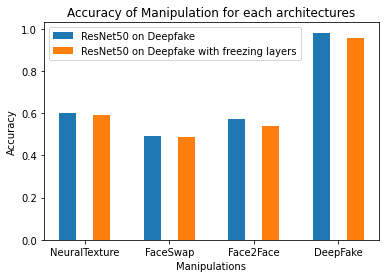

In [12]:
X_axis = np.arange(len(acc_resnet50.keys()))
# Plot the first dictionary
plt.bar(X_axis - 0.2, acc_resnet50.values(), 0.2, label = "ResNet50 on Deepfake")
plt.bar(X_axis + 0.2, acc_resnet50_f.values(), 0.2, label = "ResNet50 on Deepfake with freezing layers")

plt.xticks(X_axis, acc_resnet50.keys())
plt.xlabel("Manipulations")
plt.ylabel("Accuracy")
plt.title("Accuracy of Manipulation for each architectures")
# Add a legend to identify the different data sets
plt.legend()

plt.show()

# XCEPTION

## LOAD THE MODEL

In [19]:
model_xception_f = timm.create_model('xception', pretrained=True)
num_ftrs = model_xception_f.fc.in_features
model_xception_f.last_linear = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    #nn.Dropout(p=0.5),
    nn.Linear(512, 2) # 2 perchè è un problema di binary classification
)
model_xception_f = model_xception_f.to(device)

model_xception_f = model_xception_f.to(device)
model_xception_f.load_state_dict(torch.load("xception_face2face_50epochs_FREEZE_Def.pt"))

<All keys matched successfully>

In [20]:
model_xception = timm.create_model('xception', pretrained=True)
num_ftrs = model_xception.fc.in_features
model_xception.fc = nn.Linear(num_ftrs, 2)
model_xception = model_xception.to(device)

model_xception = model_xception.to(device)
model_xception.load_state_dict(torch.load("xception_face2face_50epochs_Adam_NORMAL_Def.pt"))

<All keys matched successfully>

##Test for each manipulation

In this section, after have loaded a model, there's a prediction using that model on the manipulation where it has been trained and on the others manipulations.

In [18]:
acc_xception = {}
path_original = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/original'

path_deepfake = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/deepfake'
good_deepfake = predict(path_original, path_deepfake, model_xception)

path_face2face = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/face2face'
good_face2face = predict(path_original, path_face2face, model_xception)

path_faceswap = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/faceswap'
good_faceswap = predict(path_original, path_faceswap, model_xception)

path_neuraltexture= '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/neuraltexture'
good_neuraltexture = predict(path_original, path_neuraltexture, model_xception)

acc_xception["NeuralTexture"] = good_neuraltexture
acc_xception["FaceSwap"] = good_faceswap
acc_xception["Face2Face"] = good_face2face
acc_xception["DeepFake"] = good_deepfake

Good: 0.5518867924528302
Good: 0.965
Good: 0.56
Good: 0.505


In [21]:
acc_xception_f = {}
path_original = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/original'

path_deepfake = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/deepfake'
good_deepfake = predict(path_original, path_deepfake, model_xception_f)

path_face2face = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/face2face'
good_face2face = predict(path_original, path_face2face, model_xception_f)

path_faceswap = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/faceswap'
good_faceswap = predict(path_original, path_faceswap, model_xception_f)

path_neuraltexture= '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/neuraltexture'
good_neuraltexture = predict(path_original, path_neuraltexture, model_xception_f)

acc_xception_f ["NeuralTexture"] = good_neuraltexture
acc_xception_f ["FaceSwap"] = good_faceswap
acc_xception_f ["Face2Face"] = good_face2face
acc_xception_f ["DeepFake"] = good_deepfake

Good: 0.5613207547169812
Good: 0.97
Good: 0.54
Good: 0.505


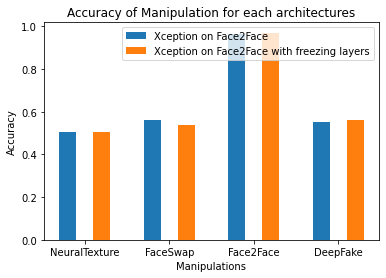

In [22]:
X_axis = np.arange(len(acc_resnet50.keys()))
# Plot the first dictionary
plt.bar(X_axis - 0.2, acc_xception.values(), 0.2, label = "Xception on Face2Face")
plt.bar(X_axis + 0.2, acc_xception_f.values(), 0.2, label = "Xception on Face2Face with freezing layers")

plt.xticks(X_axis, acc_resnet50.keys())
plt.xlabel("Manipulations")
plt.ylabel("Accuracy")
plt.title("Accuracy of Manipulation for each architectures")
# Add a legend to identify the different data sets
plt.legend()

plt.show()

# EFFICIENTNET

## LOAD THE MODEL

In [25]:
model_efficientnet = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights)

num_ftrs = model_efficientnet.classifier[1].in_features

model_efficientnet.classifier[1] = nn.Linear(num_ftrs, 2)

model_efficientnet = model_efficientnet.to(device)
model_efficientnet.load_state_dict(torch.load("efficientnet_faceswap_NORMAL.p"))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [26]:
model_efficientnet_f = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights)

num_ftrs = model_efficientnet_f.classifier[1].in_features

model_efficientnet_f.classifier[1] = nn.Linear(num_ftrs, 2)

model_efficientnetv2_f = model_efficientnet_f.to(device)
model_efficientnetv2_f.load_state_dict(torch.load("efficientnet_faceswap_FREEZE.p"))

<All keys matched successfully>

##Test for each manipulation

In this section, after have loaded a model, there's a prediction using that model on the manipulation where it has been trained and on the others manipulations.

In [27]:
acc_efficientnet = {}
path_original = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/original'

path_deepfake = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/deepfake'
good_deepfake = predict(path_original, path_deepfake, model_efficientnet)

path_face2face = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/face2face'
good_face2face = predict(path_original, path_face2face, model_efficientnet)

path_faceswap = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/faceswap'
good_faceswap = predict(path_original, path_faceswap, model_efficientnet)

path_neuraltexture= '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/neuraltexture'
good_neuraltexture = predict(path_original, path_neuraltexture, model_efficientnet)

acc_efficientnet["NeuralTexture"] = good_neuraltexture
acc_efficientnet["FaceSwap"] = good_faceswap
acc_efficientnet["Face2Face"] = good_face2face
acc_efficientnet["DeepFake"] = good_deepfake

Good: 0.4669811320754717
Good: 0.595
Good: 0.985
Good: 0.495


In [28]:
acc_efficientnet_f = {}
path_original = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/original'

path_deepfake = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/deepfake'
good_deepfake = predict(path_original, path_deepfake, model_efficientnetv2_f)

path_face2face = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/face2face'
good_face2face = predict(path_original, path_face2face, model_efficientnetv2_f)

path_faceswap = '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/faceswap'
good_faceswap = predict(path_original, path_faceswap, model_efficientnetv2_f)

path_neuraltexture= '/content/drive/MyDrive/VISIOPE_PROJECT/Dataset_test/neuraltexture'
good_neuraltexture = predict(path_original, path_neuraltexture, model_efficientnetv2_f)

acc_efficientnet_f["NeuralTexture"] = good_neuraltexture
acc_efficientnet_f["FaceSwap"] = good_faceswap
acc_efficientnet_f["Face2Face"] = good_face2face
acc_efficientnet_f["DeepFake"] = good_deepfake

Good: 0.46226415094339623
Good: 0.59
Good: 0.975
Good: 0.49


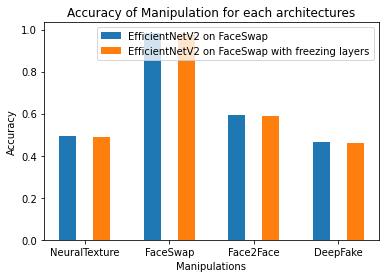

In [29]:
X_axis = np.arange(len(acc_efficientnet.keys()))
# Plot the first dictionary
plt.bar(X_axis - 0.2, acc_efficientnet.values(), 0.2, label = "EfficientNetV2 on FaceSwap")
plt.bar(X_axis + 0.2, acc_efficientnet_f.values(), 0.2, label = "EfficientNetV2 on FaceSwap with freezing layers")

plt.xticks(X_axis, acc_efficientnet.keys())
plt.xlabel("Manipulations")
plt.ylabel("Accuracy")
plt.title("Accuracy of Manipulation for each architectures")
# Add a legend to identify the different data sets
plt.legend()

plt.show()